# VQE of the Z2 lattice gauge theory

In [1]:
# The C2QA package is currently not published to PyPI.
# To use the package locally, add the C2QA repository's root folder to the path prior to importing c2qa.
import os
import sys
module_path = os.path.abspath(os.path.join("../.."))
if module_path not in sys.path:
    sys.path.append(module_path)

# Cheat to get MS Visual Studio Code Jupyter server to recognize Python venv
module_path = os.path.abspath(os.path.join("../../venv/Lib/site-packages"))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import copy
import c2qa
import qiskit
import numpy as np
import scipy
import itertools
import c2qa.util as util
import LGT_resource
import c2qa.stateReadout as stateReadout
import matplotlib.pyplot as plt
import matplotlib
# Import Qiskit
from qiskit import QuantumCircuit
from qiskit import Aer, transpile
from qiskit.tools.visualization import plot_histogram, plot_state_city
import qiskit.quantum_info as qi
from qiskit.providers.aer import AerSimulator
from qiskit import IBMQ
from collections import Counter

## Prepare initial state and act on it with H1, H2, H3

In [3]:
num_qubits=2
num_qumodes=3
qubits_per_mode=2

qmr = c2qa.QumodeRegister(num_qumodes=num_qumodes, num_qubits_per_qumode=qubits_per_mode)
qbr = qiskit.QuantumRegister(size=num_qubits)
cbr_measure_field = qiskit.ClassicalRegister(size=num_qubits, name='measure_field')
cbr_measure_hopping = qiskit.ClassicalRegister(size=num_qubits, name='measure_hopping')

init_circuit = c2qa.CVCircuit(qmr, qbr, cbr_measure_field, cbr_measure_hopping)


# initialize the qumodes
initial_qumode_state = [2,2,2]
for i in range(qmr.num_qumodes):
    init_circuit.cv_initialize(initial_qumode_state[i], qmr[i])
# initialize the qubits
for qubit in qbr:
    init_circuit.h(qubit)


num_layers = 1
params = np.random.uniform(low=0.0, high=2*np.pi, size=3 * num_layers)
z2_ansatz = LGT_resource.construct_circuit(params, copy.deepcopy(init_circuit))
    
#print(init_circuit.draw())
#print()
print(z2_ansatz.draw(fold=200))

#meas_circ = LGT_resource.compute_z2_expected_energy(z2_ansatz)
#meas_circ.draw(fold=200)

print(LGT_resource.append_and_measure_field_term(copy.deepcopy(z2_ansatz), qbr, cbr_measure_field))
print(LGT_resource.append_and_measure_hopping_term(copy.deepcopy(z2_ansatz), qmr, qbr, cbr_measure_hopping))

/Users/teague/Workspace/bosonic-isa/c2qa-qiskit/bosonEnv/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/Users/teague/Workspace/bosonic-isa/c2qa-qiskit/bosonEnv/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


                   ┌──────────────────────┐┌──────┐┌──────┐                                              
             q0_0: ┤0                     ├┤0     ├┤0     ├──────────────────────────────────────────────
                   │  initialize(0,0,1,0) ││      ││      │                                              
             q0_1: ┤1                     ├┤1     ├┤1     ├──────────────────────────────────────────────
                   ├──────────────────────┤│      ││      │               ┌──────┐┌──────┐               
             q0_2: ┤0                     ├┤2     ├┤2     ├───────────────┤0     ├┤0     ├───────────────
                   │  initialize(0,0,1,0) ││      ││      │               │      ││      │               
             q0_3: ┤1                     ├┤3 rh1 ├┤3 rh2 ├───────────────┤1     ├┤1     ├───────────────
                   ├──────────────────────┤│      ││      │               │      ││      │               
             q0_4: ┤0                     ├┤  

/Users/teague/Workspace/bosonic-isa/c2qa-qiskit/bosonEnv/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/Users/teague/Workspace/bosonic-isa/c2qa-qiskit/bosonEnv/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


In [19]:
circuit.draw(output='mpl', filename='/home/richard/PycharmProjects/c2qa/c2qa-qiskit/tutorials/Z2-lattice-gauge-theory/images/VQE.png')

<Figure size 4531.29x3578.56 with 1 Axes>

In [ ]:
def compute_exact_energy():

## VQE Loop
- Test different optimizers
- Test the effect of adding additional layers
- Compute the exact ground state energy

In [3]:
np.__version__

'1.21.5'

In [4]:
import multiprocess as mp
import time

In [5]:
def parallel_vqe(args):
    def run_vqe(num_qubits, num_qumodes, qubits_per_mode, num_layers, gauge_fluctuations, optimizer):
        out, trace, occ_hist = LGT_resource.z2_vqe(num_qubits=num_qubits,
                                         num_qumodes=num_qumodes,
                                         qubits_per_mode=qubits_per_mode,
                                         initial_qumode_state=[2,0],
                                         num_layers=num_layers,
                                         gauge_fluctuations=gauge_fluctuations,
                                         optimizer=optimizer)
        print(f'Optimization finished (N_l = {num_layers}): Final energy = {out["fun"]:.3f}')
        return num_layers, out, trace, occ_hist
    
    with mp.Pool(len(args)) as pool:
        results = pool.starmap(run_vqe, args)
            
    
    return results

In [6]:
num_qubits=1
num_qumodes=2
qubits_per_mode=2
gauge_fluctuations = 1
optimizer = 'COBYLA'

args = []
for num_layers in [1, 4, 6]:
    args.append((num_qubits, num_qumodes, qubits_per_mode, num_layers, gauge_fluctuations, optimizer))

start = time.time()
vqe_data = parallel_vqe(args)
end = time.time()
print(f'Total runtime: {(end - start):.2f} seconds')

/Users/teague/Workspace/bosonic-isa/c2qa-qiskit/bosonEnv/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/Users/teague/Workspace/bosonic-isa/c2qa-qiskit/bosonEnv/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/Users/teague/Workspace/bosonic-isa/c2qa-qiskit/bosonEnv/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/Users/teague/Workspace/bosonic-isa/c2qa-qiskit/bosonEnv/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is 

Optimization finished (N_l = 1): Final energy = -2.000
Optimization finished (N_l = 4): Final energy = -1.965
Optimization finished (N_l = 6): Final energy = -1.965
Total runtime: 103.28 seconds


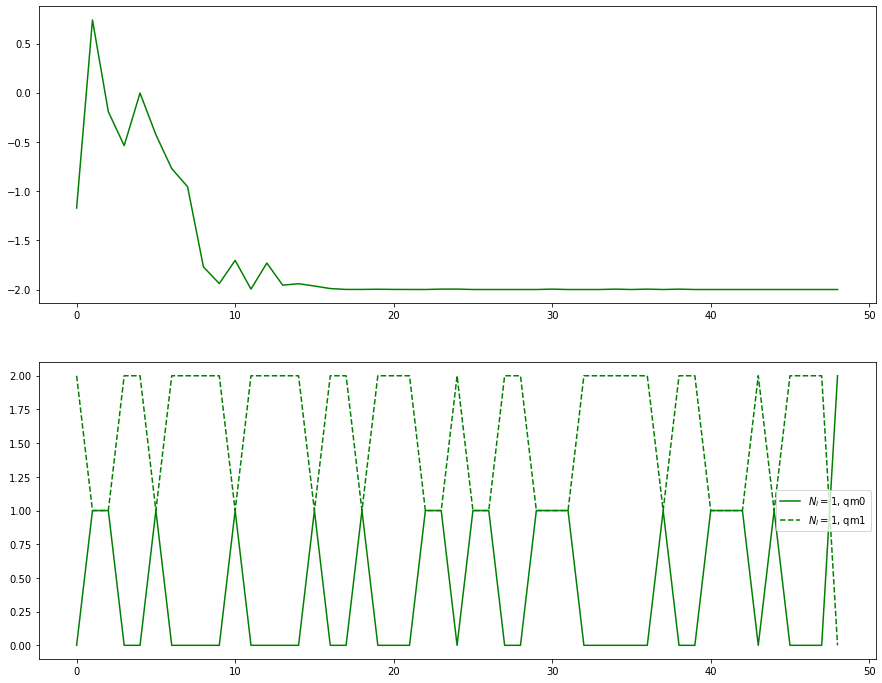

In [8]:
fig, ax = plt.subplots(nrows=2, figsize=[15,12])

colors = ['green', 'red', 'blue', 'orange']
for i, data in enumerate(vqe_data):
    if i == 0:
        num_layers, out, trace, occupation_history = data
        ax[0].plot(list(range(len(trace))), trace, label='$N_l = $' + f'{num_layers}', c=colors[i])

        qm0_occupation = [qm[0] for qm in data[3]]
        qm1_occupation = [qm[1] for qm in data[3]]
        ax[1].plot(list(range(len(trace))), qm0_occupation, label='$N_l = $' + f'{num_layers}, qm0', c=colors[i], ls='-')
        ax[1].plot(list(range(len(trace))), qm1_occupation, label='$N_l = $' + f'{num_layers}, qm1', c=colors[i], ls='--')
    
#ax.axhline(y=-3.78293464, ls='--', c='r')
    
#ax.set_title(f'{optimizer}, VQE on Z2 LGT, $\lambda = $' + f'{gauge_fluctuations}')
#ax.set_ylabel('Energy')
#ax.set_xlabel('Iteration')
ax[1].legend()

In [8]:
num_qubits=1
num_qumodes=2
qubits_per_mode=2
gauge_fluctuations = 1
optimizer = 'BFGS'

args = []
for num_layers in [1,2,3,4]:
    args.append((num_qubits, num_qumodes, qubits_per_mode, num_layers, gauge_fluctuations, optimizer))

start = time.time()
vqe_data = parallel_vqe(args)
end = time.time()
print(f'Total runtime: {(end - start):.2f} seconds')

/Users/teague/Workspace/bosonic-isa/c2qa-qiskit/bosonEnv/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/Users/teague/Workspace/bosonic-isa/c2qa-qiskit/bosonEnv/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/Users/teague/Workspace/bosonic-isa/c2qa-qiskit/bosonEnv/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/Users/teague/Workspace/bosonic-isa/c2qa-qiskit/bosonEnv/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficie

Optimization finished (N_l = 1): Final energy = -3.545


/Users/teague/Workspace/bosonic-isa/c2qa-qiskit/bosonEnv/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/Users/teague/Workspace/bosonic-isa/c2qa-qiskit/bosonEnv/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


Optimization finished (N_l = 2): Final energy = -3.328


/Users/teague/Workspace/bosonic-isa/c2qa-qiskit/bosonEnv/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/Users/teague/Workspace/bosonic-isa/c2qa-qiskit/bosonEnv/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '
/Users/teague/Workspace/bosonic-isa/c2qa-qiskit/bosonEnv/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/Users/teague/Workspace/bosonic-isa/c2qa-qiskit/bosonEnv/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format


KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots(dpi=150)

for data in vqe_data:
    num_layers, out, trace = data
    ax.plot(list(range(len(trace))), trace, label='$N_l = $' + f'{num_layers}')
ax.set_title('{optimizer}, VQE on Z2 LGT, $\lambda = $' + f'{gauge_fluctuations}')
ax.set_ylabel('Energy')
ax.set_xlabel('Iteration')
ax.legend()

## ECD protocol for creating the hopping term in H for VQE

/home/richard/anaconda3/envs/c2qa/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/home/richard/anaconda3/envs/c2qa/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


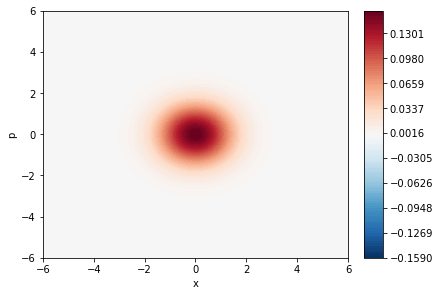

In [2]:
# The C2QA pacakge is currently not published to PyPI.
# To use the package locally, add the C2QA repository's root folder to the path prior to importing c2qa.
import os
import sys
module_path = os.path.abspath(os.path.join("../.."))
if module_path not in sys.path:
    sys.path.append(module_path)

# Cheat to get MS Visual Studio Code Jupyter server to recognize Python venv
module_path = os.path.abspath(os.path.join("../../venv/Lib/site-packages"))
if module_path not in sys.path:
    sys.path.append(module_path)

import c2qa
import qiskit
import numpy as np

# Augment the number of qubits per mode
qmr = c2qa.QumodeRegister(num_qumodes=2, num_qubits_per_qumode=2)
qbr = qiskit.QuantumRegister(size=1)
qc = c2qa.CVCircuit(qmr, qbr)

# Initialize your qubit (should have no effect on Fock state Wigner function)
qc.initialize([1,0], qbr[0])

# initialise in x (just h) or y eigenstate
qc.h(qbr[0])
qc.rz(np.pi/2,qbr[0])

# Initialize the qumode to a zero Fock sate (ie. the vaccuum)
qc.cv_initialize(0, qmr[0])
qc.cv_initialize(0, qmr[1])

qc.cv_rh1(1, qmr[0], qmr[1], qbr[0])

state, _ = c2qa.util.simulate(qc)
c2qa.util.plot_wigner(qc, state)

In [ ]:
## Measuring $\langle H \rangle$

For a given value of $\lambda$ and ansatz parameters $\vec{\theta}$ we can measure the expected energy
$\langle H \rangle$ by splitting the Hamiltonian into two parts $H = H_0 + H_1$.

## Measuring $\langle O_{n,n'} \rangle$

Using the conditional displacement operator we can measure $\sin (k \hat{x})$ of an oscillator using phase kickback.

In [3]:
%matplotlib inline

In [4]:
def measure_sin(input_circuit, qumode_reg, qubit_reg, bit_reg, alpha=1, verbose=0, shots=8192):
    
    input_circuit.h(qubit_reg[0])
    input_circuit.cv_cnd_d(alpha, -alpha, qubit_reg[0], qumode_reg[0])
    input_circuit.s(qubit_reg[0])
    input_circuit.h(qubit_reg[0])
    
    input_circuit.measure(qubit_reg[0], bit_reg[0])
    
    if verbose:
        print(input_circuit.draw())
    
    state, result = c2qa.util.simulate(circuit, shots=shots)
    counts = result.get_counts()
    
    if verbose:
        print(counts)
    
    # Compute <sigma_y>
    return (counts['0'] - counts['1']) / shots

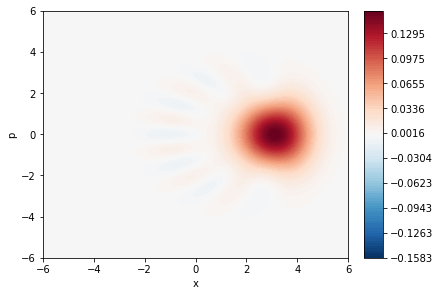

          ┌──────────────────────────────┐┌────┐┌─────┐             
qumode_0: ┤0                             ├┤0   ├┤1    ├─────────────
          │                              ││    ││     │             
qumode_1: ┤1 initialize(1,0,0,0,0,0,0,0) ├┤1 D ├┤2    ├─────────────
          │                              ││    ││  Dc │             
qumode_2: ┤2                             ├┤2   ├┤3    ├─────────────
          └────────────┬───┬─────────────┘└────┘│     │┌───┐┌───┐┌─┐
 qubit_0: ─────────────┤ H ├────────────────────┤0    ├┤ S ├┤ H ├┤M├
                       └───┘                    └─────┘└───┘└───┘└╥┘
  creg: 1/════════════════════════════════════════════════════════╩═
                                                                  0 
{'0': 1360, '1': 6832}


-0.66796875

In [7]:
qmr = c2qa.QumodeRegister(num_qumodes=1,
                          num_qubits_per_qumode=3,
                          name='qumode')
qr = qiskit.QuantumRegister(size=1, name='qubit')
cr = qiskit.ClassicalRegister(size=1, name='creg')
circuit = c2qa.CVCircuit(qmr, qr, cr)

circuit.cv_initialize(0, qmr[0])
#circuit.cv_s(0.5, qmr[0])
#circuit.cv_r(np.pi/8, qmr[0])
circuit.cv_d(np.pi/2, qmr[0])

state, result = c2qa.util.simulate(circuit)
c2qa.util.plot_wigner(circuit, state)

measure_sin(circuit, qmr, qr, cr, verbose=1, alpha=2j)

In [8]:
# Measure the coordinate x_hat of the oscillator
x_displacement = np.pi / 6

# A purely imaginary alpha will give the oscillator a momentum boost (Eqn 16)
# equivalently, this can be pictured as a rotation of the ancilla qubit
# about the Z-axis by an angle  theta(x) = -4kx
alpha_vals = np.arange(-0.5, 0.5, 0.05)
measured_vals = []
for alpha in alpha_vals:
    qmr = c2qa.QumodeRegister(num_qumodes=1,
                              num_qubits_per_qumode=3,
                              name='qumode')
    qr = qiskit.QuantumRegister(size=1, name='qubit')
    cr = qiskit.ClassicalRegister(size=1, name='creg')
    circuit = c2qa.CVCircuit(qmr, qr, cr)

    circuit.cv_initialize(0, qmr[0])
    circuit.cv_d(x_displacement, qmr[0])

    # Measuring <sigma_y> = <sin[theta(x_hat)]> = -<sin[4k(x_hat)]>
    measured_vals.append(measure_sin(circuit, qmr, qr, cr, alpha=alpha*1j))

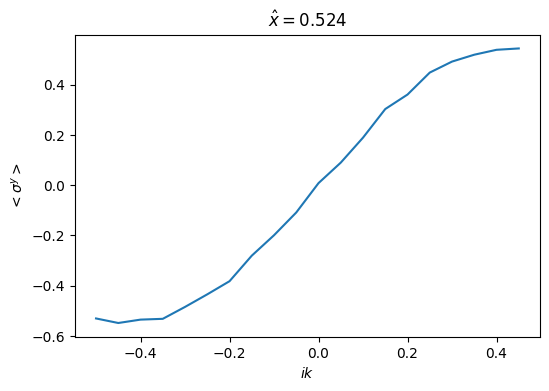

In [9]:
# Plot the expectation of <sigma_y> on the ancilla qubit
fig, ax = plt.subplots(dpi=100)
ax.plot(alpha_vals, measured_vals)
ax.set_ylabel('$<\sigma^y>$')
ax.set_xlabel('$ik$')
ax.set_title('$\hat{x} =$' + f'{x_displacement:.3f}')

plt.show()
plt.close()

-0.5000, -0.5303, -0.2795
-0.4500, -0.5483, -0.3224
-0.4000, -0.5349, -0.3528
-0.3500, -0.5317, -0.4005
-0.3000, -0.4844, -0.4214
-0.2500, -0.4343, -0.4493
-0.2000, -0.3821, -0.4901
-0.1500, -0.2805, -0.4739
-0.1000, -0.1992, -0.5014
-0.0500, -0.1086, -0.5443
-0.0000, 0.0081, 18142138127972.9453
0.0500, 0.0896, -0.4486
0.1000, 0.1890, -0.4753
0.1500, 0.3027, -0.5126
0.2000, 0.3604, -0.4608
0.2500, 0.4478, -0.4643
0.3000, 0.4915, -0.4281
0.3500, 0.5188, -0.3896
0.4000, 0.5383, -0.3553
0.4500, 0.5437, -0.3194


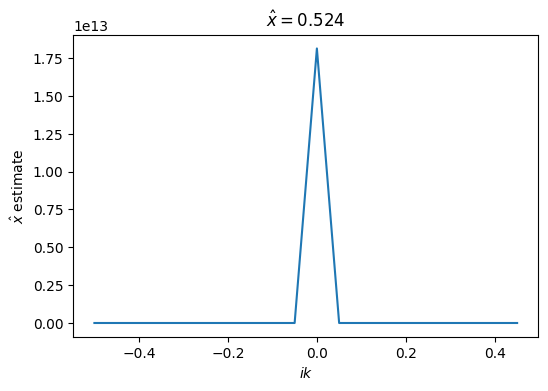

In [10]:
# Estimate the value of x_hat from the measured data
x_estimates = []
for val, k in zip(measured_vals, alpha_vals):
    x_hat = np.arcsin(-1 * val) / (4 * k) # computation can be vectorized to speedup
    print(f'{k:.4f}, {val:.4f}, {x_hat:.4f}')
    x_estimates.append(x_hat)

fig, ax = plt.subplots(dpi=100)
ax.plot(alpha_vals, x_estimates)
ax.set_ylabel('$\hat{x}$ estimate')
ax.set_xlabel('$ik$')
ax.set_title('$\hat{x} =$' + f'{x_displacement:.3f}')

plt.show()
plt.close()